In [ ]:
# Installing models and datasets
!pip install transformers datasets


Dataset from: https://huggingface.co/datasets/ybisk/piqa and referred the documentation of the dataset which is in this the same link i have provided. (papers with code)

In [ ]:
from datasets import load_dataset

# Loading PiQA dataset
piqa = load_dataset("piqa")
print(piqa)
print(piqa['train'][0])  # Displaying a sample from the training set


DatasetDict({
    train: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 16113
    })
    test: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 3084
    })
    validation: Dataset({
        features: ['goal', 'sol1', 'sol2', 'label'],
        num_rows: 1838
    })
})
{'goal': "When boiling butter, when it's ready, you can", 'sol1': 'Pour it onto a plate', 'sol2': 'Pour it into a jar', 'label': 1}


In [ ]:
# Preprocessing function to format inputs for models
def preprocess_function(examples):
    return {
        "inputs": [
            f"Question: {q} Answer Choices: 1) {a1} 2) {a2}"
            for q, a1, a2 in zip(examples["goal"], examples["sol1"], examples["sol2"])
        ],
        "labels": examples["label"],
    }

# Apply preprocessing to the validation set
validation_data = piqa["validation"].map(preprocess_function, batched=True)

# Displaying preprocessed data
print(validation_data[0])


{'goal': "How do I ready a guinea pig cage for it's new occupants?", 'sol1': 'Provide the guinea pig with a cage full of a few inches of bedding made of ripped paper strips, you will also need to supply it with a water bottle and a food dish.', 'sol2': 'Provide the guinea pig with a cage full of a few inches of bedding made of ripped jeans material, you will also need to supply it with a water bottle and a food dish.', 'label': 0, 'inputs': "Question: How do I ready a guinea pig cage for it's new occupants? Answer Choices: 1) Provide the guinea pig with a cage full of a few inches of bedding made of ripped paper strips, you will also need to supply it with a water bottle and a food dish. 2) Provide the guinea pig with a cage full of a few inches of bedding made of ripped jeans material, you will also need to supply it with a water bottle and a food dish.", 'labels': 0}


Citation: https://huggingface.co/FacebookAI/roberta-large and referred few code lines from the model documentation: https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaForMaskedLM


In [ ]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice
import torch

# Loading RoBERTa model and tokenizer
model_name = "roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMultipleChoice.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #using GPU when available for faster processing
model.to(device)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForMultipleChoice(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
     

Referred from the multiple choice part from the different model (https://huggingface.co/docs/transformers/en/tasks/multiple_choice)

In [ ]:
def tokenize_function(examples):
    # Combining question with each answer choice
    first_sentences = [[q] * 2 for q in examples["goal"]]
    second_sentences = [examples["sol1"], examples["sol2"]]

    # Flattening the lists for tokenization
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenizing as (question, choice) pairs
    # Limiting max length to make sure the tokens wont exceed max token limit of model.
    tokenized = tokenizer(
        first_sentences,
        second_sentences,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt",
    )

    # Reshaping inputs back into (question, choices)
    tokenized = {key: val.view(-1, 2, val.size(-1)) for key, val in tokenized.items()}
    tokenized["labels"] = torch.tensor(examples["label"])
    return tokenized

# Applying the tokenize function to the validation data
validation_tokenized = validation_data.map(tokenize_function, batched=True)
print(validation_tokenized[0])


Map:   0%|          | 0/1838 [00:00<?, ? examples/s]

{'goal': "How do I ready a guinea pig cage for it's new occupants?", 'sol1': 'Provide the guinea pig with a cage full of a few inches of bedding made of ripped paper strips, you will also need to supply it with a water bottle and a food dish.', 'sol2': 'Provide the guinea pig with a cage full of a few inches of bedding made of ripped jeans material, you will also need to supply it with a water bottle and a food dish.', 'label': 0, 'inputs': "Question: How do I ready a guinea pig cage for it's new occupants? Answer Choices: 1) Provide the guinea pig with a cage full of a few inches of bedding made of ripped paper strips, you will also need to supply it with a water bottle and a food dish. 2) Provide the guinea pig with a cage full of a few inches of bedding made of ripped jeans material, you will also need to supply it with a water bottle and a food dish.", 'labels': 0, 'input_ids': [[0, 6179, 109, 38, 1227, 10, 11843, 33581, 13280, 16051, 13, 24, 18, 92, 19062, 116, 2, 2, 35746, 1949, 

In [ ]:
from torch.utils.data import DataLoader

# Converting the tokenized data into a DataLoader for batch processing(read this documentation https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader and done this)
validation_loader = DataLoader(validation_tokenized, batch_size=16, shuffle=False)


In [ ]:
# Ensure the dataset returns PyTorch tensors(data loader documentation:https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
validation_tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]  # Columns to include
)
validation_loader = DataLoader(validation_tokenized, batch_size=16, shuffle=False)

In [ ]:
model.eval()

correct = 0
total = 0

# Disabling gradient calculation with torch.no_grad() for inference, as gradients are of no use during evaluation.
# as we aren't updating model parameters this saves memory and speeds up process.

with torch.no_grad():
    for batch in validation_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Comparing predictions with true labels
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Calculating accuracy
accuracy = correct / total
print(f"RoBERTa Accuracy on PiQA: {accuracy * 100:.2f}%")


RoBERTa Accuracy on PiQA: 50.44%


I read the model documentation https://huggingface.co/docs/transformers/main/en/model_doc/gpt2#transformers.GPT2LMHeadModel before proceeding into the code part,based on that i have done this.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Loading GPT-2 model and tokenizer
model_name = "gpt2-medium"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [ ]:
def gpt2_score_choices(examples): # this function evaluates all 2 possible choices for each question in the dataset using GPT 2
    scores = []
    for i, question in enumerate(examples["goal"]):
        # Formatting the input for each choice
        inputs_1 = tokenizer(question + " " + examples["sol1"][i], return_tensors="pt").to(device)
        inputs_2 = tokenizer(question + " " + examples["sol2"][i], return_tensors="pt").to(device)

        # Calculating the loss for each choice
        with torch.no_grad():
            loss_1 = model(**inputs_1, labels=inputs_1["input_ids"]).loss.item()
            loss_2 = model(**inputs_2, labels=inputs_2["input_ids"]).loss.item()

        # Append scores: lower loss = better choice
        scores.append(0 if loss_1 < loss_2 else 1)

    return scores


In [ ]:
# Evaluating GPT-2 on a subset of validation data for fast processing
subset = validation_tokenized.select(range(100))

# Computing predictions
gpt2_predictions = gpt2_score_choices(subset)

# Comparing predictions with true labels (compares model predicted answers to the actual correct answers given in the dataset)
correct = sum([1 if pred == label else 0 for pred, label in zip(gpt2_predictions, subset["labels"])])
total = len(subset)

# Calculating accuracy
gpt2_accuracy = correct / total
print(f"GPT-2 Accuracy on PiQA: {gpt2_accuracy * 100:.2f}%")


GPT-2 Accuracy on PiQA: 72.00%


In [ ]:
# Comparing of Model Performance
roberta_accuracy = 50.44
gpt2_accuracy = 72.00

print(f"Comparison of Model Performance on PiQA:")
print(f"RoBERTa Accuracy: {roberta_accuracy:.2f}%")
print(f"GPT-2 Accuracy: {gpt2_accuracy:.2f}%")


Comparison of Model Performance on PiQA:
RoBERTa Accuracy: 50.44%
GPT-2 Accuracy: 72.00%


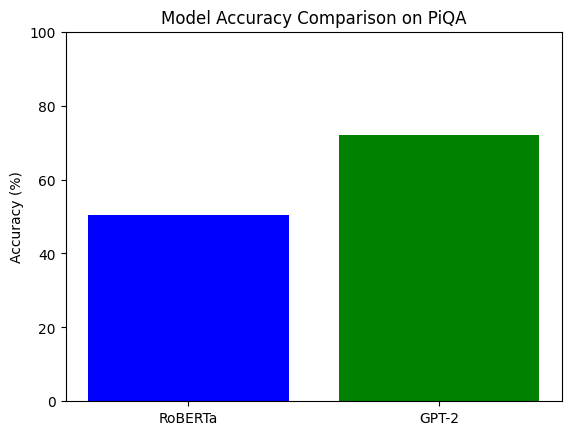

In [ ]:
import matplotlib.pyplot as plt
models = ["RoBERTa", "GPT-2"]
accuracies = [roberta_accuracy, gpt2_accuracy]

# Creating bar chart
plt.bar(models, accuracies, color=["blue", "green"])
plt.title("Model Accuracy Comparison on PiQA")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.show()
